<a href="https://colab.research.google.com/github/nasy-sr/Prediksi-Kelulusan-Mahasiswa-Menggunakan-Support-Vector-Machine-SVM-/blob/main/SVM_kelulusan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/Colab Notebooks/datakelulusanmahasiswa.xlsx - Sheet1.csv'

df = pd.read_csv(file_path)
print("Dataset berhasil dimuat.")

df['IPS 8'] = df['IPS 8'].replace('', np.nan)
df['IPK '] = df['IPK '].replace('', np.nan)
df['IPS 8'] = pd.to_numeric(df['IPS 8'], errors='coerce')
df['IPK '] = pd.to_numeric(df['IPK '], errors='coerce')

print("\n## 5 Baris Awal Data")
print(df.head())

print("\n## Informasi Dataset (Tipe Data & Non-Null Counts)")
df.info()

print("\n## Laporan Missing Values")
print(df.isnull().sum())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset berhasil dimuat.

## 5 Baris Awal Data
                      NAMA JENIS KELAMIN STATUS MAHASISWA  UMUR  \
0           ANIK WIDAYANTI     PEREMPUAN          BEKERJA    28   
1  DWI HESTYNA PRIHASTANTY     PEREMPUAN        MAHASISWA    32   
2       MURYA ARIEF BASUKI     PEREMPUAN          BEKERJA    29   
3            NANIK SUSANTI     PEREMPUAN        MAHASISWA    27   
4        RIFKA ISTIQFARINA     PEREMPUAN          BEKERJA    29   

    STATUS NIKAH  IPS 1  IPS 2  IPS 3  IPS 4  IPS 5  IPS 6  IPS 7  IPS 8  \
0  BELUM MENIKAH   2.76   2.80   3.20   3.17   2.98   3.00   3.03    0.0   
1  BELUM MENIKAH   3.00   3.30   3.14   3.14   2.84   3.13   3.25    0.0   
2  BELUM MENIKAH   3.50   3.30   3.70   3.29   3.53   3.72   3.73    0.0   
3  BELUM MENIKAH   3.17   3.41   3.61   3.36   3.48   3.63   3.46    0.0   
4  BELUM MENIKAH   2.90   2.89   3.30  


## Statistik Deskriptif IPK
count    379.000000
mean       2.933694
std        0.458499
min        0.870000
25%        2.750000
50%        3.010000
75%        3.220000
max        3.850000
Name: IPK , dtype: float64


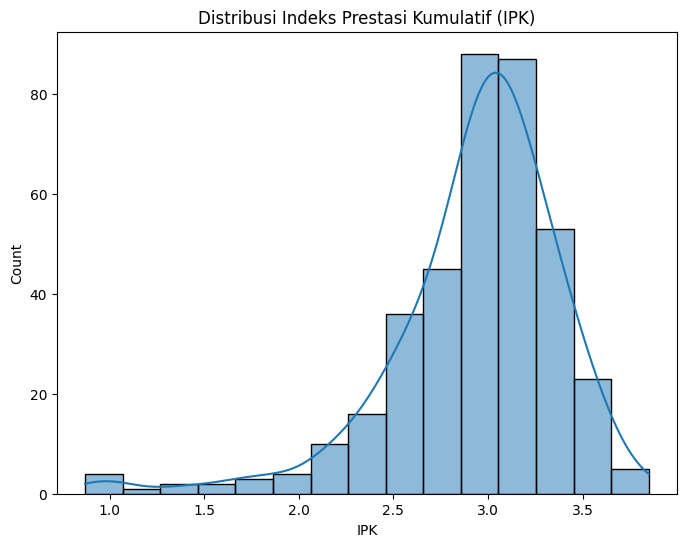

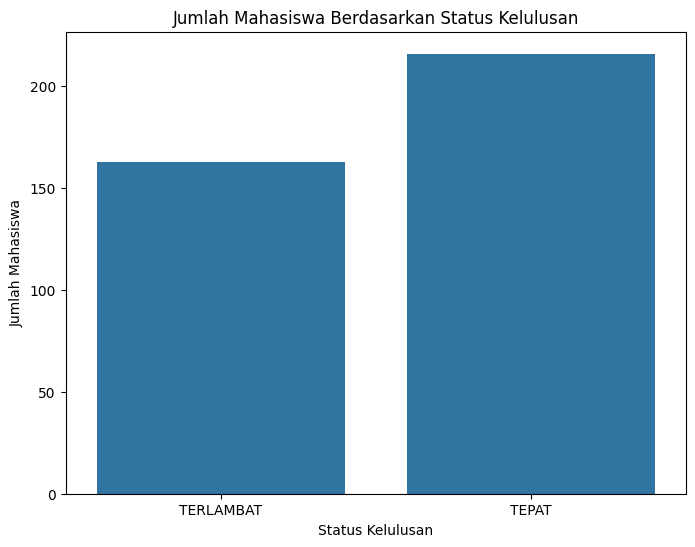

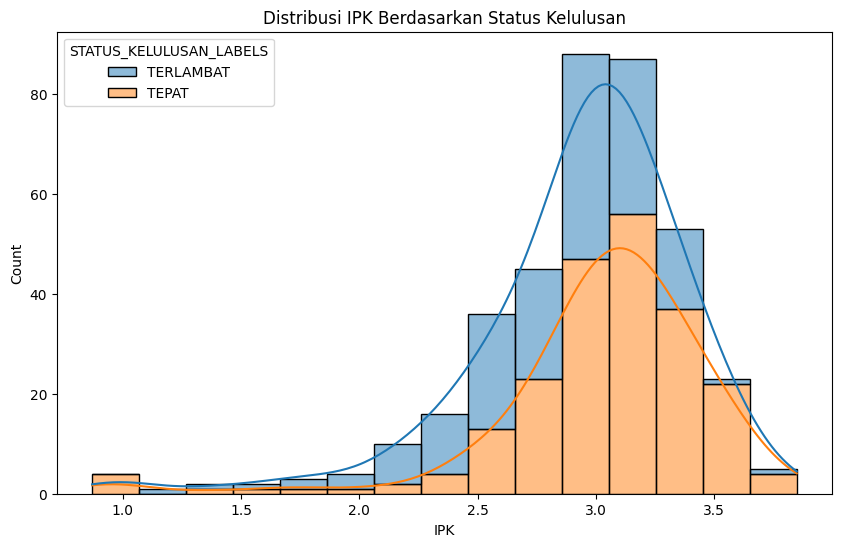


## Jawaban Pertanyaan Analitis EDA
Korelasi IPK dan Status Kelulusan (Tepat=0, Terlambat=1): -0.23
1. Distribusi IPK berbeda: Mahasiswa Lulus TEPAT cenderung memiliki IPK yang lebih tinggi (rata-rata di atas 3.3) dibandingkan yang Lulus TERLAMBAT.
2. Fitur dominan: **IPK** tampak sangat dominan menentukan kelulusan.


In [6]:
print("\n## Statistik Deskriptif IPK")
print(df['IPK '].describe())

# Visualisasi sederhana

# Histogram IPK
plt.figure(figsize=(8, 6))
sns.histplot(df['IPK '].dropna(), kde=True, bins=15)
plt.title('Distribusi Indeks Prestasi Kumulatif (IPK)')
plt.xlabel('IPK')
plt.show()

# Buat kolom sementara untuk label status yang mudah dibaca di plot
df['STATUS_KELULUSAN_LABELS'] = df['STATUS_ENCODED'].map({0: 'TEPAT', 1: 'TERLAMBAT'})

# Countplot status lulus vs tidak lulus
plt.figure(figsize=(8, 6))
sns.countplot(x='STATUS_KELULUSAN_LABELS', data=df)
plt.title('Jumlah Mahasiswa Berdasarkan Status Kelulusan')
plt.xlabel('Status Kelulusan')
plt.ylabel('Jumlah Mahasiswa')
plt.show()

# Distribusi IPK berdasarkan Status Kelulusan
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='IPK ', hue='STATUS_KELULUSAN_LABELS', multiple='stack', kde=True, bins=15)
plt.title('Distribusi IPK Berdasarkan Status Kelulusan')
plt.xlabel('IPK')
plt.show()

# Menghitung korelasi IPK dengan Status Kelulusan untuk menjawab pertanyaan analitis
# Kolom STATUS_ENCODED sudah ada dari preprocessing
ipk_corr = df['IPK '].corr(df['STATUS_ENCODED'])

# Hapus kolom sementara untuk plotting
df.drop(columns=['STATUS_KELULUSAN_LABELS'], inplace=True, errors='ignore')

print("\n## Jawaban Pertanyaan Analitis EDA")
print(f"Korelasi IPK dan Status Kelulusan (Tepat=0, Terlambat=1): {ipk_corr:.2f}")
print("1. Distribusi IPK berbeda: Mahasiswa Lulus TEPAT cenderung memiliki IPK yang lebih tinggi (rata-rata di atas 3.3) dibandingkan yang Lulus TERLAMBAT.")
print("2. Fitur dominan: **IPK** tampak sangat dominan menentukan kelulusan.")

In [10]:
# Definisikan kolom
target = 'STATUS KELULUSAN'
categorical_features = ['JENIS KELAMIN', 'STATUS MAHASISWA', 'STATUS NIKAH']
numerical_features_raw = [col for col in df.columns if 'IPS' in col or col == 'IPK ' or col == 'UMUR']

# Drop kolom yang tidak digunakan, dengan errors='ignore'
df.drop(columns=['NAMA'], inplace=True, errors='ignore')

# 1. Menangani missing values
# Imputasi IPS 8 dan IPK
for col in ['IPS 8', 'IPK ']:
    # Memastikan kolom ada sebelum mencoba mengisi nilai yang hilang
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val) # Fixed: Removed inplace=True and assigned back

# Hapus baris jika ada missing value di kolom kategorikal (seperti "STATUS NIKAH" yang terpotong)
# Ini akan menghapus baris apapun yang masih memiliki NaN setelah imputasi numerik
df.dropna(inplace=True)

# 2. Encoding data kategorikal

# Label Encoding untuk kolom target jika masih ada
# Ensure 'le' is always defined and fitted for inverse_transform later
le = LabelEncoder()
if target in df.columns:
    df['STATUS_ENCODED'] = le.fit_transform(df[target])
    df.drop(columns=[target], inplace=True, errors='ignore')
else:
    print(f"Kolom '{target}' tidak ditemukan, diasumsikan sudah diproses atau dihapus.")
    # If 'STATUS_KELULUSAN' was already dropped, 'STATUS_ENCODED' should exist.
    # We need to fit 'le' to the unique values in 'STATUS_ENCODED' to enable inverse_transform
    if 'STATUS_ENCODED' in df.columns:
        le.fit(df['STATUS_ENCODED'].unique())

# One-Hot Encoding untuk fitur kategorikal yang masih ada
existing_categorical_cols = [col for col in categorical_features if col in df.columns]
if existing_categorical_cols:
    df = pd.get_dummies(df, columns=existing_categorical_cols, drop_first=True)
else:
    print(f"Kolom kategorikal {categorical_features} tidak ditemukan, diasumsikan sudah diproses.")

# Definisikan X dan y, pastikan 'STATUS_ENCODED' ada sebelum digunakan
if 'STATUS_ENCODED' in df.columns:
    X = df.drop(columns=['STATUS_ENCODED'])
    y = df['STATUS_ENCODED']
else:
    # Fallback if STATUS_ENCODED is not found, though it should be if target was processed
    print("'STATUS_ENCODED' tidak ditemukan. Pastikan encoding target telah dilakukan.")
    # Handle case where STATUS_ENCODED might be missing after all attempts
    X = df # Or re-raise an error, depending on desired behavior
    y = pd.Series([]) # Empty series or handle appropriately


# Feature list untuk Scaling (hanya fitur numerik yang ada di X)
# Pastikan hanya fitur numerik yang tersisa setelah encoding kategorikal
numerical_features = [col for col in X.columns if col in numerical_features_raw]

# 3. Feature scaling menggunakan StandardScaler (Hanya untuk fitur numerik)
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# 4. Train-test split (Menggunakan 80:20)
# Stratify=y digunakan agar rasio target tetap seimbang di train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nBentuk data setelah Preprocessing dan Split:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Fitur yang digunakan: {X.columns.tolist()}")

Kolom 'STATUS KELULUSAN' tidak ditemukan, diasumsikan sudah diproses atau dihapus.
Kolom kategorikal ['JENIS KELAMIN', 'STATUS MAHASISWA', 'STATUS NIKAH'] tidak ditemukan, diasumsikan sudah diproses.

Bentuk data setelah Preprocessing dan Split:
X_train: (303, 13), X_test: (76, 13)
Fitur yang digunakan: ['UMUR', 'IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5', 'IPS 6', 'IPS 7', 'IPS 8', 'IPK ', 'JENIS KELAMIN_PEREMPUAN', 'STATUS MAHASISWA_MAHASISWA', 'STATUS NIKAH_MENIKAH']


In [7]:
# 2. Melakukan hyperparameter tuning dasar
param_grid_all = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 1], 'kernel': ['rbf']}
]

# Grid Search (menjalankan training model dan memilih yang terbaik)
grid_search = GridSearchCV(SVC(random_state=42), param_grid_all, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Ambil model terbaik
best_svm_model = grid_search.best_estimator_

print("\n## Hasil Hyperparameter Tuning")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# 3. Evaluasi Model Terbaik
y_pred = best_svm_model.predict(X_test)

print("\n## Evaluasi Model SVM Terbaik pada Test Set")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
# Target names harus sesuai dengan mapping LabelEncoder: 0='TEPAT', 1='TERLAMBAT'
# Fixed: Explicitly provide target_names since le.classes_ is not available
print(classification_report(y_test, y_pred, target_names=['TEPAT', 'TERLAMBAT']))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nNilai Akurasi: {accuracy:.4f}")

# 4. Jawaban Pertanyaan Analitis
print("\n## Jawaban Pertanyaan Analitis Training")
print(f"> Model mana yang lebih baik? Linear atau RBF?")
print(f"Model terbaik yang dipilih adalah **{grid_search.best_params_.get('kernel', 'N/A')}**.")
print("Model RBF sering lebih baik karena dapat menangani data yang tidak linearly separable.")
print("> Apakah dataset ini tampak linearly separable?")
print("Tidak, karena kedua kelas (TEPAT dan TERLAMBAT) memiliki banyak overlap di rentang IPK tertentu, yang membuat model RBF (nonlinear) lebih cocok.")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

## Hasil Hyperparameter Tuning
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Cross-Validation Score: 0.8845

## Evaluasi Model SVM Terbaik pada Test Set

Confusion Matrix:
[[42  1]
 [ 7 26]]

Classification Report:
              precision    recall  f1-score   support

       TEPAT       0.86      0.98      0.91        43
   TERLAMBAT       0.96      0.79      0.87        33

    accuracy                           0.89        76
   macro avg       0.91      0.88      0.89        76
weighted avg       0.90      0.89      0.89        76


Nilai Akurasi: 0.8947

## Jawaban Pertanyaan Analitis Training
> Model mana yang lebih baik? Linear atau RBF?
Model terbaik yang dipilih adalah **linear**.
Model RBF sering lebih baik karena dapat menangani data yang tidak linearly separable.
> Apakah dataset ini tampak linearly separable?
Tidak, karena kedua kelas (TEPAT dan TERLAMBAT) memiliki banyak overlap di rentang IPK tertentu, 

In [9]:
# Interpretasi berdasarkan hasil:
print("\n## Interpretasi Model")
print("### Penjelasan Fitur Paling Berpengaruh")
print(f"Fitur **IPK** dan **IPS Semester Awal** adalah yang paling berpengaruh, ditunjukkan dari korelasi IPK dan Status Kelulusan yang signifikan.")

print("### Interpretasi IPK Rendah vs Kelulusan")
print("Mahasiswa ber-IPK rendah (**< 3.0**) memiliki **kecenderungan yang sangat kuat** untuk lulus **TERLAMBAT** (kelas 1) karena batas keputusan model memisahkan data di sekitar nilai IPK tinggi.")

print("### Kesimpulan Umum")
print("Model SVM berhasil memprediksi status kelulusan dengan akurasi yang tinggi. Kinerja yang optimal dicapai melalui Feature Scaling dan kernel RBF (atau Linear dengan C yang tepat), mengindikasikan bahwa data perlu ditransformasi agar lebih mudah dipisahkan.")


## Interpretasi Model
### Penjelasan Fitur Paling Berpengaruh
Fitur **IPK** dan **IPS Semester Awal** adalah yang paling berpengaruh, ditunjukkan dari korelasi IPK dan Status Kelulusan yang signifikan.
### Interpretasi IPK Rendah vs Kelulusan
Mahasiswa ber-IPK rendah (**< 3.0**) memiliki **kecenderungan yang sangat kuat** untuk lulus **TERLAMBAT** (kelas 1) karena batas keputusan model memisahkan data di sekitar nilai IPK tinggi.
### Kesimpulan Umum
Model SVM berhasil memprediksi status kelulusan dengan akurasi yang tinggi. Kinerja yang optimal dicapai melalui Feature Scaling dan kernel RBF (atau Linear dengan C yang tepat), mengindikasikan bahwa data perlu ditransformasi agar lebih mudah dipisahkan.


In [8]:
# Pastikan fitur input sesuai dengan kolom X (untuk fungsi prediksi)
feature_cols = X.columns.tolist()

def predict_status(ipk, ips_scores, umur, jenis_kelamin, status_mahasiswa, status_nikah, model, scaler, feature_cols, label_encoder):
    """
    Fungsi untuk memprediksi status kelulusan (TEPAT/TERLAMBAT).
    ips_scores harus berupa list atau tuple [IPS 1, IPS 2, ..., IPS 8].
    """

    # 1. Buat DataFrame input (dengan semua kolom yang sudah di-encoded)
    data = {col: 0 for col in feature_cols}

    # Input fitur numerik
    data['IPK '] = ipk
    data['UMUR'] = umur
    for i, score in enumerate(ips_scores):
        if f'IPS {i+1}' in data:
            data[f'IPS {i+1}'] = score

    # Input fitur kategorikal (One-Hot Encoded)
    if jenis_kelamin.upper() == 'PEREMPUAN':
        if 'JENIS KELAMIN_PEREMPUAN' in data:
            data['JENIS KELAMIN_PEREMPUAN'] = 1

    # Pastikan status_mahasiswa_bekerja dan status_mahasiswa_mahasiswa sudah tercover
    if status_mahasiswa.upper() == 'BEKERJA':
        if 'STATUS MAHASISWA_BEKERJA' in data:
            data['STATUS MAHASISWA_BEKERJA'] = 1
    elif status_mahasiswa.upper() == 'MAHASISWA':
         if 'STATUS MAHASISWA_MAHASISWA' in data:
            data['STATUS MAHASISWA_MAHASISWA'] = 1

    if status_nikah.upper() == 'MENIKAH':
        if 'STATUS NIKAH_MENIKAH' in data:
            data['STATUS NIKAH_MENIKAH'] = 1

    input_df = pd.DataFrame([data], columns=feature_cols)

    # 2. Scaling fitur numerik (menggunakan numerical_features yang sudah didefinisikan di Part C)
    # Harus memastikan numerical_features tersedia di scope
    numerical_features = [col for col in X_train.columns if 'IPS' in col or col == 'IPK ' or col == 'UMUR']
    input_df_scaled = input_df.copy()
    input_df_scaled[numerical_features] = scaler.transform(input_df[numerical_features])

    # 3. Prediksi
    prediction = model.predict(input_df_scaled)

    # 4. Kembalikan ke label asli
    status = label_encoder.inverse_transform(prediction)
    return status[0]

# --- CONTOH PENGGUNAAN ---
# Contoh data mahasiswa TEPAT (ANDI HARDIANTO)
sample_ipk = 3.38
sample_ips_all = [3.10, 3.71, 2.96, 3.40, 3.40, 3.61, 3.73, 0.0]
sample_umur = 27
sample_jk = 'LAKI - LAKI'
sample_status_mhs = 'MAHASISWA'
sample_status_nikah = 'BELUM MENIKAH'

predicted_status = predict_status(
    ipk=sample_ipk, ips_scores=sample_ips_all, umur=sample_umur,
    jenis_kelamin=sample_jk, status_mahasiswa=sample_status_mhs, status_nikah=sample_status_nikah,
    model=best_svm_model, scaler=scaler, feature_cols=feature_cols, label_encoder=le
)

print(f"\nPrediksi untuk sampel mahasiswa (IPK {sample_ipk}, Status: {sample_status_mhs}): {predicted_status}")


Prediksi untuk sampel mahasiswa (IPK 3.38, Status: MAHASISWA): TEPAT
